# !!.

In [1]:
%load_ext autoreload
%autoreload 2

# Necessary imports
import sys
import warnings
warnings.filterwarnings("ignore")

sys.path.insert(0, '../../..')
from batchflow import Pipeline, Notifier, set_gpus
from batchflow import B, C, P, R, M
from batchflow.models.torch import TorchModel, ResBlock

from seismiqb import SeismicDataset, Horizon
from seismiqb import SeismicSampler, Accumulator3D, RegularGrid

# Set GPU
set_gpus(n=1, min_free_memory=0.4);

`CUDA_VISIBLE_DEVICES` set to "1"


In [2]:
# Global parameters
CROP_SHAPE = (1, 256, 256)       # shape of sampled 3D crops
BATCH_SIZE = 64                  # number of crops inside one batch

<a id='dataset'></a>
# Dataset
* Use DVC to download seismic data
* install `batchflow`, `seismiqb`
* Use `seismiqb/datasets/01_Convert_cubes.ipynb` to convert it to `qblosc`

In [3]:
cube_path = '/data/seismic_data/seismic_interpretation/001_YETYPUR/001_YETYPUR.qblosc'

dataset = SeismicDataset(cube_path)
field = dataset[0]

In [4]:
print(field.geometry)


Processed geometry for cube    /data/seismic_data/seismic_interpretation/001_YETYPUR/001_YETYPUR.qblosc
Current index:                 ['INLINE_3D', 'CROSSLINE_3D']
Cube shape:                    (2563, 1409, 1501)
Time delay:                    50
Sample rate:                   2.0
Area:                          1522.4 km²

SEG-Y original size:           21.000 GB
Current cube size:             4.910 GB
Size of the instance:          0.102 GB

Number of traces:              3611267
Number of non-zero traces:     2435820
Fullness:                      0.67

Original cube values:
Number of uniques:                    192
mean | std:                          0.12 | 1887.29   
min | max:                      -47429.45 | 39240.19  
q01 | q99:                       -5459.50 | 5118.29   

Quantized cube info:
Error of quantization:              0.041
Ranges:                          -5118.29 | 5118.29   



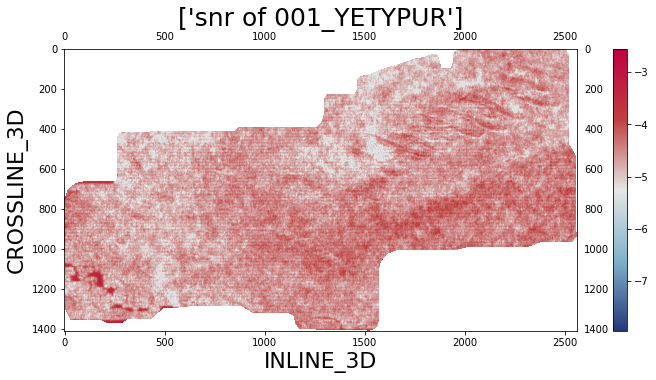

In [5]:
field.show()

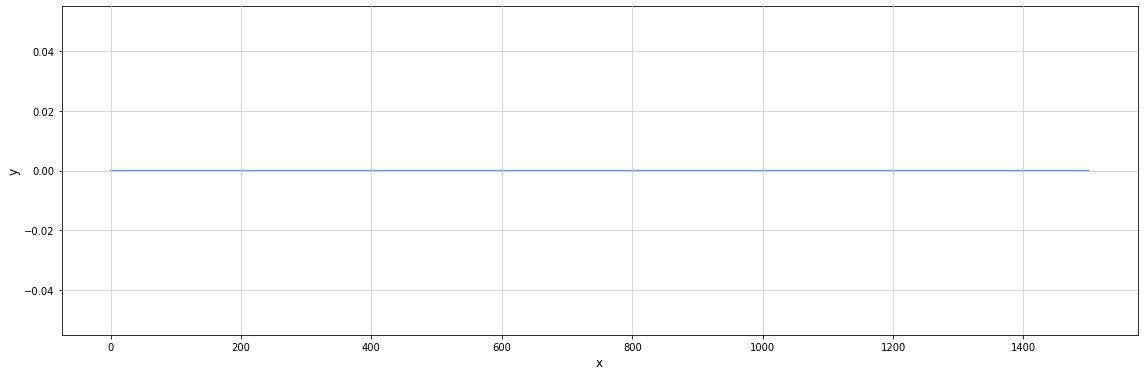

In [6]:
from seismiqb import plot
plot(field.geometry[300, 300], mode='curve')

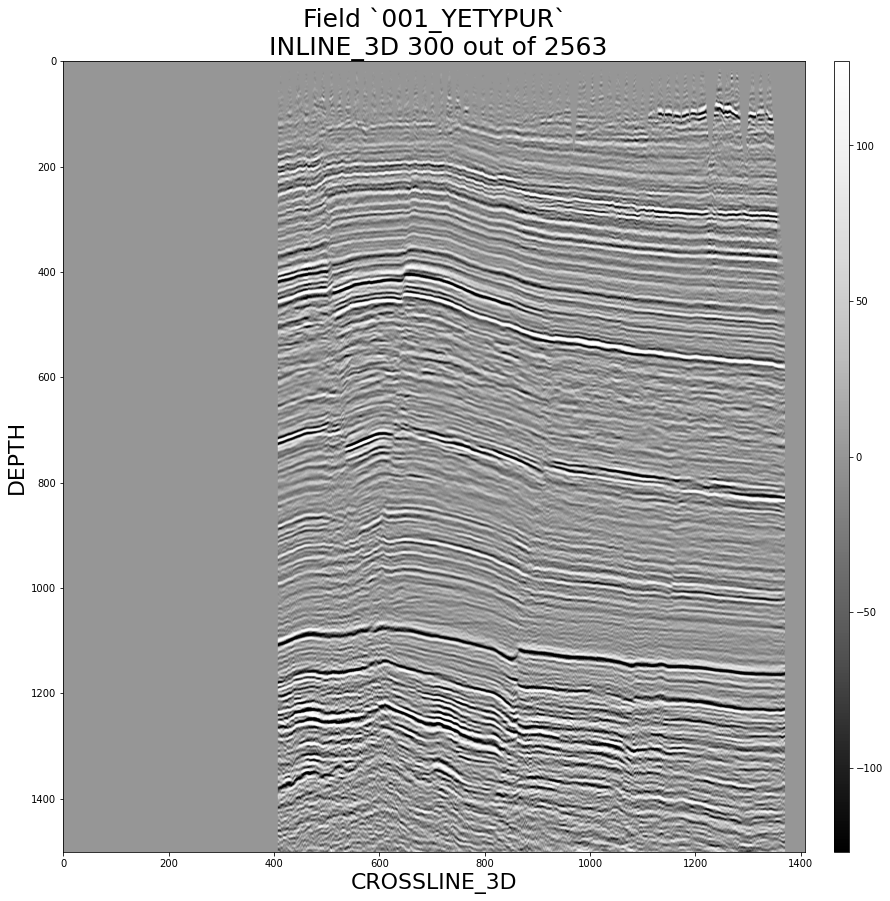

In [7]:
field.show_slide(300, axis=0, scale=1.5)

CPU times: user 7.74 s, sys: 458 ms, total: 8.2 s
Wall time: 7.82 s


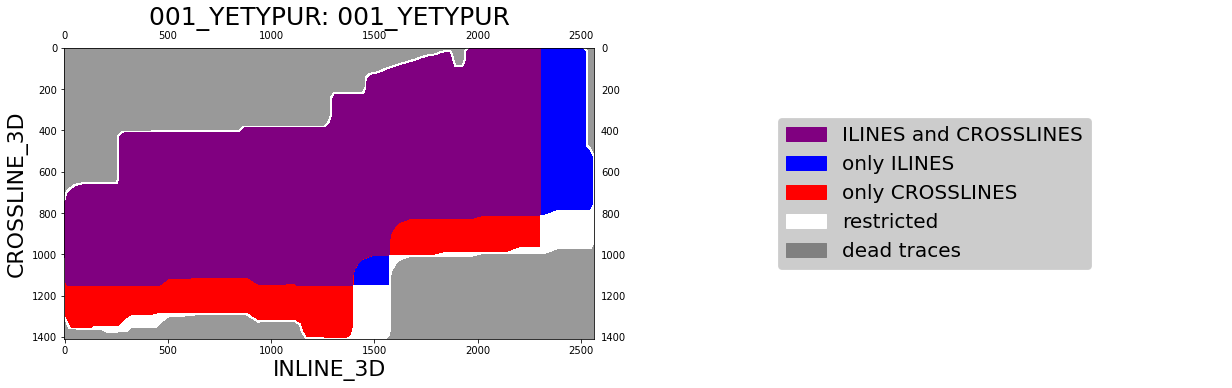

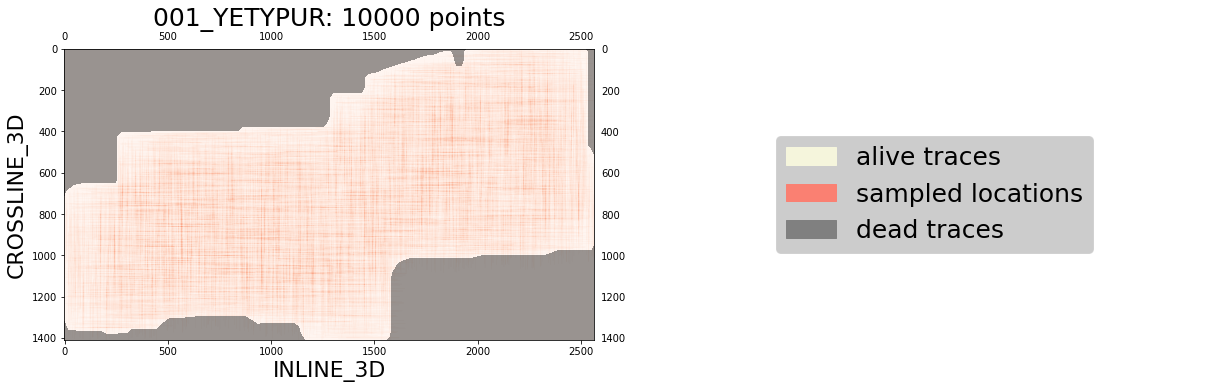

In [8]:
%%time
train_sampler = SeismicSampler(labels=dataset.geometries, crop_shape=CROP_SHAPE,
                               threshold=0.7, shift_height=(0.7, 0.3))

train_sampler.show_locations()
train_sampler.show_sampled()

In [9]:
%%time
test_sampler = SeismicSampler(labels=dataset.labels, crop_shape=CROP_SHAPE,
                              threshold=0.7, shift_height=(0.7, 0.3))

test_sampler.show_locations()
test_sampler.show_sampled()

ValueError: Labels contain different classes, set()!

<a id='training'></a>
# Training

Pipeline of training consists of following steps:

- First of all, we create locations of crops to cut (`make_locations` action)
- Then we create masks and load actual seismic data
- As some of the crops are `iline`-oriented, and some of them are `xline`-oriented, we need to force equal shape on all of them. That is what `adaptive_reshape` for!
- We normalize seismic data by standard scaling: this way, most of the data is in $[-3, 3]$ range

In [10]:
train_template = (
    Pipeline()
    # Initialize model
    # .init_model(name='model', model_class=TorchModel, config=MODEL_CONFIG)

    # Load data/masks
    .make_locations(generator=train_sampler, batch_size=BATCH_SIZE)
    .load_cubes(dst='images')
    .adaptive_reshape(src=['images'])
    .normalize(src='images')
    
    # Possible augmentations

    # Training
    # .train_model('model', inputs=B('images'), targets=B('masks'))
)

train_pipeline = train_template << dataset

In [11]:
%%time
batch = train_pipeline.next_batch()

CPU times: user 292 ms, sys: 144 ms, total: 435 ms
Wall time: 224 ms


In [12]:
batch.images.shape

(64, 1, 256, 256)

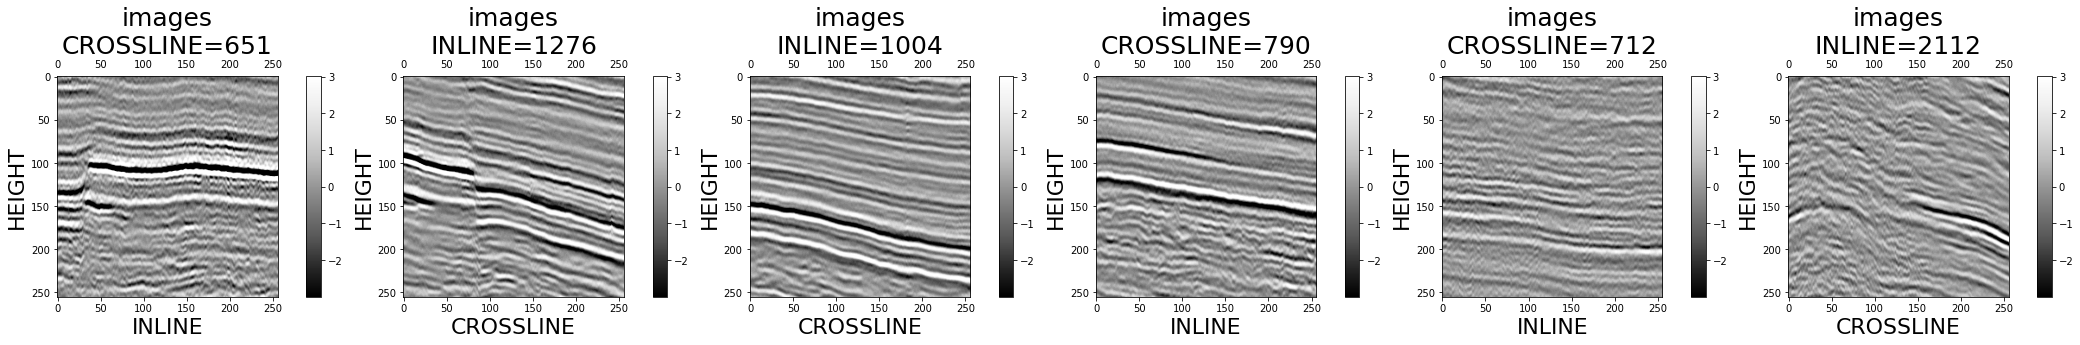

In [13]:
batch.plot_roll(n=6, ncols=6, combine='separate', colorbar=True, labelright=False)

100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.15it/s]


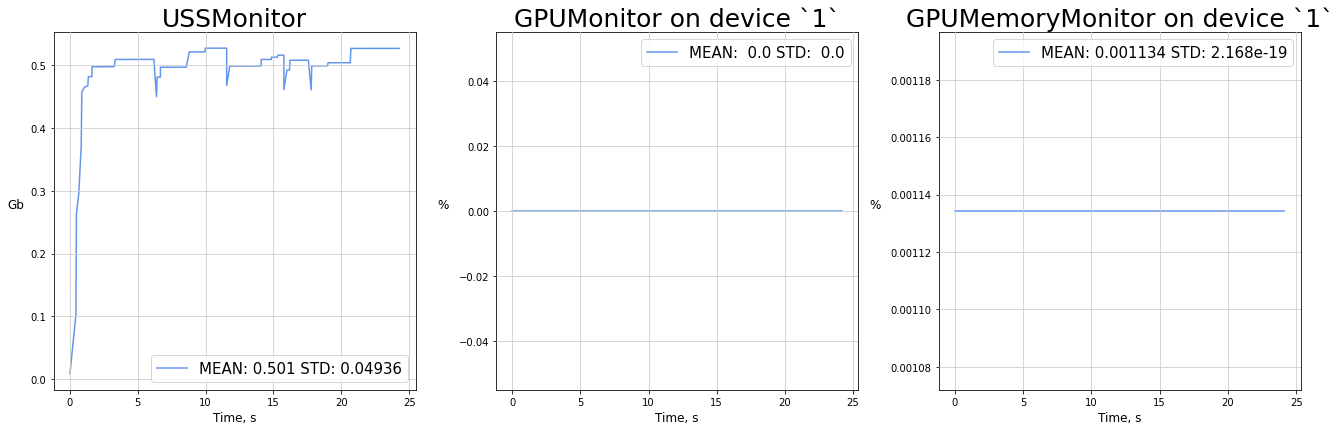

CPU times: user 32.1 s, sys: 13.4 s, total: 45.5 s
Wall time: 25.2 s


In [14]:
%%time
notifier = Notifier('t', monitors=['uss', 'gpu', 'gpu_memory'])
train_pipeline.run(n_iters=100, notifier=notifier)

notifier.plot()

In [15]:
# # Check info about model
# model = train_pipeline.m('model')
# model.plot_loss(legend_size=12)

# model.information()

# Profile the pipeline

In [16]:
%%time
train_pipeline.run(n_iters=100, notifier='t', profile=2)

train_pipeline.show_profile_info()

100%|█████████████████████████████████████████| 100/100 [00:21<00:00,  4.59it/s]
CPU times: user 33.3 s, sys: 2.88 s, total: 36.2 s
Wall time: 22.1 s


total_time                      eval_time            \
                           sum      mean       max        sum      mean   
action                                                                    
load_cubes #1        16.625211  0.166252  0.477015  16.623406  0.166234   
normalize #3          2.029667  0.020297  0.025213   2.027946  0.020279   
adaptive_reshape #2   1.142929  0.011429  0.023902   1.141125  0.011411   
make_locations #0     0.305436  0.003054  0.006980   0.303993  0.003040   

                               
                          max  
action                         
load_cubes #1        0.476997  
normalize #3         0.025193  
adaptive_reshape #2  0.023882  
make_locations #0    0.006958

In [17]:
train_pipeline.show_profile_info(detailed=True, limit=5)

ncalls  \
                                                                          sum   
action              id                                                          
adaptive_reshape #2 <built-in method numpy.core._multiarray_umath.i...    100   
                    __getattr__::~::0::<built-in method builtins.ge...  51200   
                    get::/notebooks/tsimfer/SeismicSolutions/notebo...  12800   
                    <built-in method builtins.getattr>::/notebooks/...  25600   
                    adaptive_reshape::/notebooks/tsimfer/SeismicSol...    100   
load_cubes #1       <built-in method zlib.crc32>::/opt/conda/lib/py...  12278   
                    <built-in method blosc.blosc_extension.decompre...   6139   
                    <method 'read' of '_io.BufferedReader' objects>...  24556   
                    read::/notebooks/tsimfer/SeismicSolutions/noteb...   6139   
                    <method 'spawn' of 'numpy.random.bit_generator....   6400   
make_locations #0   _randbelow_with_getrandbits::/opt/conda/lib/pyt...  76800   
                    choice::/notebooks/tsimfer/SeismicSolutions/not...  76800   
                    <listcomp>::/notebooks/tsimfer/SeismicSolutions...    100   
                    <genexpr>::~::0::<method 'join' of 'str' objects>   83200   
                    sample::/notebooks/tsimfer/SeismicSolutions/not...    200   
normalize #3        <built-in method numpy.core._multiarray_umath.i...  13000   
                    <method 'copy' of 'numpy.ndarray' objects>::/no...   6400   
                    normalize::/notebooks/tsimfer/SeismicSolutions/...   6400   
                    __getattr__::~::0::<built-in method builtins.ge...  25800   
                    <method 'spawn' of 'numpy.random.bit_generator....   6400   

                                                                                \
                                                                          mean   
action              id                                                           
adaptive_reshape #2 <built-in method numpy.core._multiarray_umath.i...    1.00   
                    __getattr__::~::0::<built-in method builtins.ge...  128.00   
                    get::/notebooks/tsimfer/SeismicSolutions/notebo...  128.00   
                    <built-in method builtins.getattr>::/notebooks/...  256.00   
                    adaptive_reshape::/notebooks/tsimfer/SeismicSol...    1.00   
load_cubes #1       <built-in method zlib.crc32>::/opt/conda/lib/py...  122.78   
                    <built-in method blosc.blosc_extension.decompre...   61.39   
                    <method 'read' of '_io.BufferedReader' objects>...  245.56   
                    read::/notebooks/tsimfer/SeismicSolutions/noteb...   61.39   
                    <method 'spawn' of 'numpy.random.bit_generator....   64.00   
make_locations #0   _randbelow_with_getrandbits::/opt/conda/lib/pyt...  768.00   
                    choice::/notebooks/tsimfer/SeismicSolutions/not...  768.00   
                    <listcomp>::/notebooks/tsimfer/SeismicSolutions...    1.00   
                    <genexpr>::~::0::<method 'join' of 'str' objects>   832.00   
                    sample::/notebooks/tsimfer/SeismicSolutions/not...    1.00   
normalize #3        <built-in method numpy.core._multiarray_umath.i...  130.00   
                    <method 'copy' of 'numpy.ndarray' objects>::/no...   64.00   
                    normalize::/notebooks/tsimfer/SeismicSolutions/...   64.00   
                    __getattr__::~::0::<built-in method builtins.ge...   64.50   
                    <method 'spawn' of 'numpy.random.bit_generator....   64.00   

                                                                             \
                                                                        max   
action              id                                                        
adaptive_reshape #2 <built-in method numpy.core._multiarray_umath.i...    1   
    

In [18]:
%%prun
train_pipeline.run(n_iters=100, notifier='t')

100%|█████████████████████████████████████████| 100/100 [00:20<00:00,  4.98it/s]
 

         4470382 function calls (4305767 primitive calls) in 20.086 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    18474    6.547    0.000    6.547    0.000 {built-in method zlib.crc32}
     6158    4.091    0.001    4.091    0.001 {built-in method blosc.blosc_extension.decompress_ptr}
    24632    1.731    0.000    1.731    0.000 {method 'read' of '_io.BufferedReader' objects}
61109/60909    0.859    0.000    1.007    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    18474    0.786    0.000    9.174    0.000 zipfile.py:917(read)
     6400    0.319    0.000    0.319    0.000 {method 'copy' of 'numpy.ndarray' objects}
    38400    0.299    0.000    1.789    0.000 crop_batch.py:129(get)
    25700    0.297    0.000    0.727    0.000 dataset.py:85(__getattr__)
    12903    0.273    0.000    0.373    0.000 {method 'spawn' of 'numpy.random.bit_generator.SeedSequence' objects}
     6400    0.26

In [19]:
# Below is not tested templates
raise

RuntimeError: No active exception to reraise

<a id='validation'></a>
# Validation on patches

Now we can use the model on previously unseen data. We use our `test_sampler`, that generates points from all around the cube and allows us to thoroughly examine model performance:

In [ ]:
# Validation pipeline: no augmentations
val_template = (
    Pipeline()
    # Import model
    .import_model(name='model', source=model)

    # Load data/masks
    .make_locations(generator=test_sampler, batch_size=16)
    .load_cubes(dst='images')
    .adaptive_reshape(src=['images'])
    .normalize(src='images')

    # Predict with model
    .predict_model('model',
                   inputs=B('images'),
                   outputs='sigmoid',
                   save_to=B('predictions'))
)
val_pipeline = val_template << dataset

In [ ]:
batch = val_pipeline.next_batch()

# Inference

Now is the perfect time to use our model to reconstruct the whole horizon: we can do so by:
- splitting the cube into chunks that cover the entire seismic range
- for each of them, make a prediction with the model
- aggregate predictions into one giant 3D array
- extract the horizon surface from it

Next cells do exactly that: `make_grid` creates grid of crop-sized chunks, `inference_pipeline` is used to make predictions, and `from_mask` method of `Horizon` allows us to locate the surface inside 3D array.

In [ ]:
inference_template = (
    Pipeline()
    # Import model
    .import_model(name='model', source=model)

    # Load data
    .make_locations(generator=C('grid'))
    .load_cubes(dst='images')
    .adaptive_reshape(src='images')
    .normalize(src='images')

    # Predict with model, then aggregate
    .predict_model('model', inputs=B('images'),
                   outputs='sigmoid', save_to=B('predictions'))
    .update_accumulator(src='predictions', accumulator=C('accumulator'))
)

We use a `RegularGrid` to create define locations of crops that would cover the desired range. 

`Accumulator3D` is continuously updated with new predictions, allowing us to reduce memory footprint: instead of keeping all of them in memory and aggregating later, we use and discard them right away.

In [ ]:
%%time
ranges = [None, None, [0, 1250]]

grid_i = RegularGrid(field=field, orientation=0, ranges=ranges,
                     overlap_factor=1.1, batch_size=BATCH_SIZE*4, crop_shape=CROP_SHAPE)


grid = grid_i

accumulator = Accumulator3D.from_grid(grid=grid, aggregation='mean', fill_value=0.0)

inference_pipeline = inference_template << carcass_dataset << {'grid': grid, 'accumulator': accumulator}

In [ ]:
%%time
notifier = Notifier('t', monitors=['uss', 'gpu', 'gpu_memory'])
inference_pipeline.run(n_iters=grid.n_iters, notifier=notifier, prefetch=2)
notifier.plot()

In [ ]:
%%time
aggregated = accumulator.aggregate()